In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras_preprocessing.image import ImageDataGenerator

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
dataset_dir = 'dataset_images_03s_128x128'
original_labels = ("Electronic", "Experimental", "Folk", "Hip-Hop", "Instrumental", "International", "Pop", "Rock")

image_size = (128,128)
color_mode = 'grayscale'
batch_size = 16

In [4]:
splitfolders.ratio('dataset_images_03s_128x128', output='dataset_images_03s_128x128_split', seed=1337, ratio=(0.8, 0.15,0.05)) 

Copying files: 79940 files [01:28, 908.14 files/s]


In [43]:
train_path = 'dataset_images_03s_128x128_split/train'
validation_path = 'dataset_images_03s_128x128_split/val'
test_path = 'dataset_images_03s_128x128_split/test'

def generator(path, aug):
    if aug == 1:
        image_gen = ImageDataGenerator(
            rescale=1./255,  
            zoom_range=0.1,  
            width_shift_range=0.1,  
            height_shift_range=0.1,  
            fill_mode='nearest'  
    )
    else:
        image_gen = ImageDataGenerator(rescale = 1/255.0)

    gen = image_gen.flow_from_directory(
        directory = path,
        target_size = (128,128),
        color_mode = 'grayscale',
        batch_size = 16,
        class_mode = 'categorical',
        shuffle = True,
        seed = 42
    )
    return gen

train_gen = generator(train_path, 0) # no augmentation
validation_gen = generator(validation_path, 0)
test_gen = generator(test_path, 0)

Found 63952 images belonging to 8 classes.
Found 11989 images belonging to 8 classes.
Found 3999 images belonging to 8 classes.


In [6]:
def initiate_model():
    model = Sequential()

    model.add(Conv2D(32, input_shape=(128,128,1), kernel_size=(7,7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, kernel_size=(7,7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, kernel_size=(7,7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, kernel_size=(7,7), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(5,5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
              
    model.add(Dense(1024,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(8,activation='softmax'))

    return model

In [9]:
# callbacks

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.00001, patience=4, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1)
model_checkpoint = ModelCheckpoint('checkpoints/mdl_wts.h5', save_best_only=True, monitor='val_accuracy', mode='max')
csv_logger = CSVLogger('training.log')

# optimizers 
adam = Adam(learning_rate = 0.001)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

In [10]:
# model 1: Adam, batch of 16, no augmentation, Conv-dropout = 0.4

model_1 = initiate_model()
model_1.compile(loss=tf.keras.losses.categorical_crossentropy, metrics='accuracy',optimizer=adam)
history_1 = model_1.fit(train_gen, validation_data=validation_gen, epochs = 100, callbacks = [reduce_lr, early_stopping, model_checkpoint, csv_logger])

Epoch 1/100
3997/3997 [==============================] - 140s 34ms/step - loss: 1.8914 - accuracy: 0.3201 - val_loss: 2.5479 - val_accuracy: 0.2398 - lr: 0.0010
Epoch 2/100
3997/3997 [==============================] - 136s 34ms/step - loss: 1.6267 - accuracy: 0.4131 - val_loss: 2.3774 - val_accuracy: 0.2259 - lr: 0.0010
Epoch 3/100
3997/3997 [==============================] - 136s 34ms/step - loss: 1.5220 - accuracy: 0.4620 - val_loss: 1.6038 - val_accuracy: 0.4097 - lr: 0.0010
Epoch 4/100
3997/3997 [==============================] - 135s 34ms/step - loss: 1.4608 - accuracy: 0.4865 - val_loss: 1.5611 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 5/100
3997/3997 [==============================] - 139s 35ms/step - loss: 1.4008 - accuracy: 0.5113 - val_loss: 1.4554 - val_accuracy: 0.4823 - lr: 0.0010
Epoch 6/100
3997/3997 [==============================] - 136s 34ms/step - loss: 1.3421 - accuracy: 0.5327 - val_loss: 1.3118 - val_accuracy: 0.5428 - lr: 0.0010
Epoch 7/100
3997/3997 [===========

In [11]:
model_1.evaluate(test_gen)

250/250 [==============================] - 26s 104ms/step - loss: 0.6923 - accuracy: 0.8000


[0.6923049688339233, 0.7999500036239624]

In [17]:
model_1_best = load_model('checkpoints\CNN_80%_B16_NO-AUG_T2.h5')
model_1_best_temp = model_1_best
model_1_best.evaluate(test_gen)

250/250 [==============================] - 6s 22ms/step - loss: 0.6890 - accuracy: 0.8035


[0.6890215277671814, 0.803450882434845]

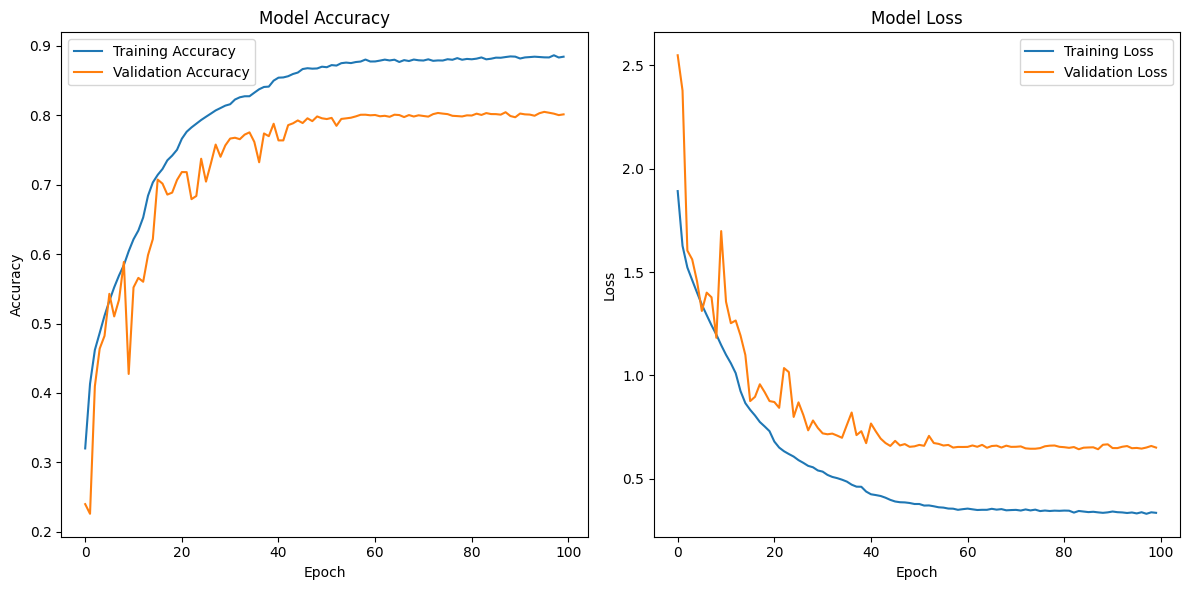

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy'); plt.ylabel('Accuracy'); plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss'); plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
for layer in model_1_best.layers[:-7]:
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.training = False

In [20]:
model_1_best = model_1_best_temp

In [21]:
# 2nd training session

model_1.compile(loss=tf.keras.losses.categorical_crossentropy, metrics='accuracy',optimizer=adam)
history_1 = model_1.fit(train_gen, validation_data=validation_gen, epochs = 100, callbacks = [reduce_lr, early_stopping, model_checkpoint, csv_logger])

Epoch 1/100
3997/3997 [==============================] - 138s 34ms/step - loss: 0.3361 - accuracy: 0.8842 - val_loss: 0.6538 - val_accuracy: 0.8017 - lr: 1.0000e-05
Epoch 2/100
3997/3997 [==============================] - 136s 34ms/step - loss: 0.3345 - accuracy: 0.8853 - val_loss: 0.6485 - val_accuracy: 0.8042 - lr: 1.0000e-05
Epoch 3/100
3997/3997 [==============================] - 136s 34ms/step - loss: 0.3299 - accuracy: 0.8883 - val_loss: 0.6488 - val_accuracy: 0.8040 - lr: 1.0000e-05
Epoch 4/100
3997/3997 [==============================] - 136s 34ms/step - loss: 0.3311 - accuracy: 0.8855 - val_loss: 0.6427 - val_accuracy: 0.8047 - lr: 1.0000e-05
Epoch 5/100
3997/3997 [==============================] - 137s 34ms/step - loss: 0.3263 - accuracy: 0.8871 - val_loss: 0.6453 - val_accuracy: 0.8046 - lr: 1.0000e-05
Epoch 6/100
3997/3997 [==============================] - 146s 36ms/step - loss: 0.3349 - accuracy: 0.8861 - val_loss: 0.6446 - val_accuracy: 0.8052 - lr: 1.0000e-05
Epoch 7/10

In [26]:
model_1_best = load_model('checkpoints\CNN_81%_B16_NO-AUG_T2.h5')
model_1_best.evaluate(test_gen)

250/250 [==============================] - 6s 23ms/step - loss: 0.6790 - accuracy: 0.8110


[0.6790119409561157, 0.8109527230262756]

In [46]:
history_1 = model_1_best.fit(train_gen, validation_data=validation_gen, epochs = 100, callbacks = [reduce_lr, early_stopping, model_checkpoint, csv_logger])

Epoch 1/100
 897/3997 [=====>........................] - ETA: 1:54 - loss: 0.2099 - accuracy: 0.9291

KeyboardInterrupt: 

In [35]:
model_1_best = load_model('checkpoints\CNN_81%_B16_NO-AUG_T3.h5')
model_1_best.evaluate(test_gen)

250/250 [==============================] - 6s 23ms/step - loss: 0.6763 - accuracy: 0.8127


[0.6763340830802917, 0.8127031922340393]

In [37]:
history_1 = model_1_best.fit(train_gen, validation_data=validation_gen, epochs = 300, callbacks = [reduce_lr, model_checkpoint, csv_logger])

Epoch 1/300
3997/3997 [==============================] - 195s 49ms/step - loss: 0.2793 - accuracy: 0.9036 - val_loss: 0.6385 - val_accuracy: 0.8138 - lr: 1.0000e-05
Epoch 2/300
3997/3997 [==============================] - 149s 37ms/step - loss: 0.2833 - accuracy: 0.9028 - val_loss: 0.6362 - val_accuracy: 0.8126 - lr: 1.0000e-05
Epoch 3/300
3997/3997 [==============================] - 141s 35ms/step - loss: 0.2853 - accuracy: 0.9026 - val_loss: 0.6307 - val_accuracy: 0.8140 - lr: 1.0000e-05
Epoch 4/300
3997/3997 [==============================] - 136s 34ms/step - loss: 0.2833 - accuracy: 0.9036 - val_loss: 0.6479 - val_accuracy: 0.8093 - lr: 1.0000e-05
Epoch 5/300
3997/3997 [==============================] - 136s 34ms/step - loss: 0.2826 - accuracy: 0.9024 - val_loss: 0.6443 - val_accuracy: 0.8113 - lr: 1.0000e-05
Epoch 6/300
3997/3997 [==============================] - 136s 34ms/step - loss: 0.2825 - accuracy: 0.9033 - val_loss: 0.6490 - val_accuracy: 0.8100 - lr: 1.0000e-05
Epoch 7/30

KeyboardInterrupt: 

In [42]:
model_1_best = load_model('checkpoints\mdl_wts.h5')
model_1_best.evaluate(test_gen)

250/250 [==============================] - 6s 22ms/step - loss: 0.6820 - accuracy: 0.8157


[0.6819954514503479, 0.8157039284706116]

In [44]:
model_1_best.fit(train_gen, validation_data=validation_gen, epochs = 300, callbacks = [reduce_lr, model_checkpoint, csv_logger])

Epoch 1/300
3997/3997 [==============================] - 136s 34ms/step - loss: 0.2623 - accuracy: 0.9117 - val_loss: 0.6428 - val_accuracy: 0.8159 - lr: 1.0000e-05
Epoch 2/300
3997/3997 [==============================] - 147s 37ms/step - loss: 0.2588 - accuracy: 0.9113 - val_loss: 0.6334 - val_accuracy: 0.8157 - lr: 1.0000e-05
Epoch 3/300
3997/3997 [==============================] - 135s 34ms/step - loss: 0.2616 - accuracy: 0.9104 - val_loss: 0.6374 - val_accuracy: 0.8140 - lr: 1.0000e-05
Epoch 4/300
3997/3997 [==============================] - 136s 34ms/step - loss: 0.2591 - accuracy: 0.9112 - val_loss: 0.6484 - val_accuracy: 0.8132 - lr: 1.0000e-05
Epoch 5/300
3997/3997 [==============================] - 135s 34ms/step - loss: 0.2586 - accuracy: 0.9115 - val_loss: 0.6399 - val_accuracy: 0.8165 - lr: 1.0000e-05
Epoch 6/300
3997/3997 [==============================] - 137s 34ms/step - loss: 0.2648 - accuracy: 0.9099 - val_loss: 0.6404 - val_accuracy: 0.8138 - lr: 1.0000e-05
Epoch 7/30

In [47]:
model_1_best.fit(train_gen, validation_data=validation_gen, epochs = 300, callbacks = [reduce_lr, model_checkpoint, csv_logger])

Epoch 1/300
3997/3997 [==============================] - 146s 37ms/step - loss: 0.2035 - accuracy: 0.9307 - val_loss: 0.6422 - val_accuracy: 0.8262 - lr: 1.0000e-05
Epoch 2/300
3997/3997 [==============================] - 139s 35ms/step - loss: 0.2040 - accuracy: 0.9312 - val_loss: 0.6509 - val_accuracy: 0.8246 - lr: 1.0000e-05
Epoch 3/300
3997/3997 [==============================] - 135s 34ms/step - loss: 0.2002 - accuracy: 0.9312 - val_loss: 0.6384 - val_accuracy: 0.8260 - lr: 1.0000e-05
Epoch 4/300
3997/3997 [==============================] - 134s 34ms/step - loss: 0.2029 - accuracy: 0.9302 - val_loss: 0.6484 - val_accuracy: 0.8252 - lr: 1.0000e-05
Epoch 5/300
3997/3997 [==============================] - 136s 34ms/step - loss: 0.2024 - accuracy: 0.9323 - val_loss: 0.6428 - val_accuracy: 0.8258 - lr: 1.0000e-05
Epoch 6/300
3997/3997 [==============================] - 142s 36ms/step - loss: 0.1968 - accuracy: 0.9326 - val_loss: 0.6447 - val_accuracy: 0.8238 - lr: 1.0000e-05
Epoch 7/30